In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Dataset/KHDL/data_final

Mounted at /content/drive
/content/drive/MyDrive/Dataset/KHDL/data_final


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **PHÂN TÍCH DỮ LIỆU CÁC BÀI BÁO ĐIỆN TỬ ĐỂ PHÂN LOẠI THEO CHỦ ĐỀ**

**Phát biểu bài toán**

***Biến mục tiêu (Y)***: category (chủ đề của bài báo: Giáo dục, Pháp luật, Khoa học, Sức khỏe, Kinh doanh, Giải trí, Thế giới, Vắn hóa, Du lịch). Đây là biến danh mục, nên bài toán mô hình hóa sẽ là phân lớp (**classification**).

***Các đặc trưng (Xi)***:
*   title: Tiêu đề bài báo.
*   description: Mô tả ngắn của bài báo.
*   content: Nội dung bài báo.
*   author: Tác giả bài báo.
*   link: Đường dẫn bài báo.




# **1. Thu thập dữ liệu**




**Cách thức thu thập**

Nguồn dữ liệu: trang báo điện tử VNExpress (https://vnexpress.net), Dân trí (https://dantri.com.vn), Tuổi trẻ (https://tuoitre.vn/).

**Quy trình thu thập:**
*   Viết script Python để truy cập và thu thập từng chuyên mục/đường dẫn cụ thể trên các trang web.
*   Sử dụng BeautifulSoup để trích xuất các thẻ HTML chứa thông tin cần thiết,
dùng Selenium để cuộn trang.
*  Lưu dữ liệu vào file CSV với các cột: title, description, content, category, author, link, category.


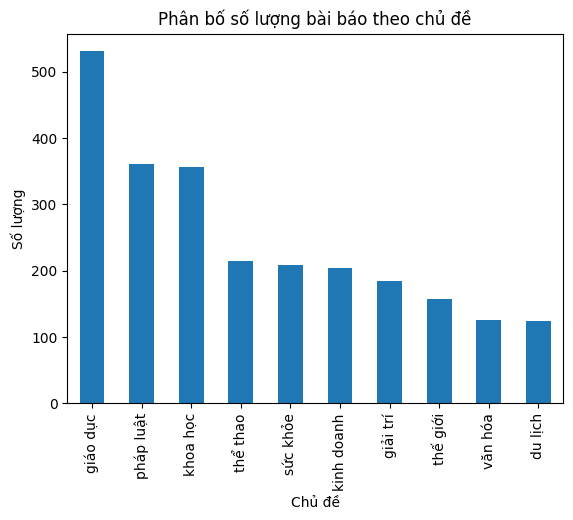

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV
df = pd.read_csv('crawl_data_articles.csv')

# Thống kê số lượng bài báo theo chủ đề
category_counts = df['category'].value_counts()
category_counts.plot(kind='bar')
plt.title('Phân bố số lượng bài báo theo chủ đề')
plt.xlabel('Chủ đề')
plt.ylabel('Số lượng')
plt.show()

# **2. Xử lý dữ liệu**
**Bước đã thực hiện**:
*  Ghép từ đơn thành từ ghép.
*  Loại bỏ cột trống và trùng lặp(vì chiếm tỉ lệ nhỏ).
*  Chuyển văn bản về chữ thường.
*  Loại bỏ dấu câu, chuẩn hóa khoảng trắng.
*  Loại bỏ stopwords.

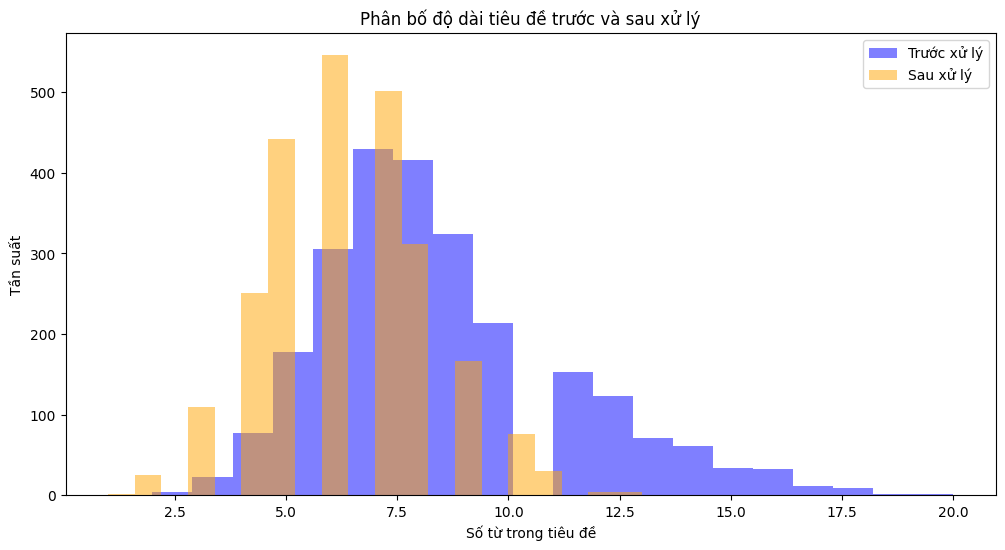

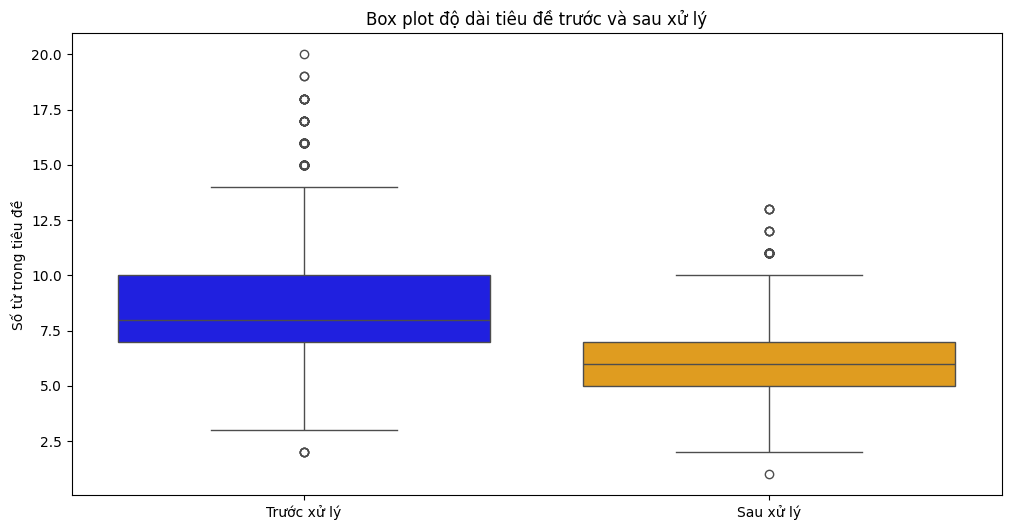

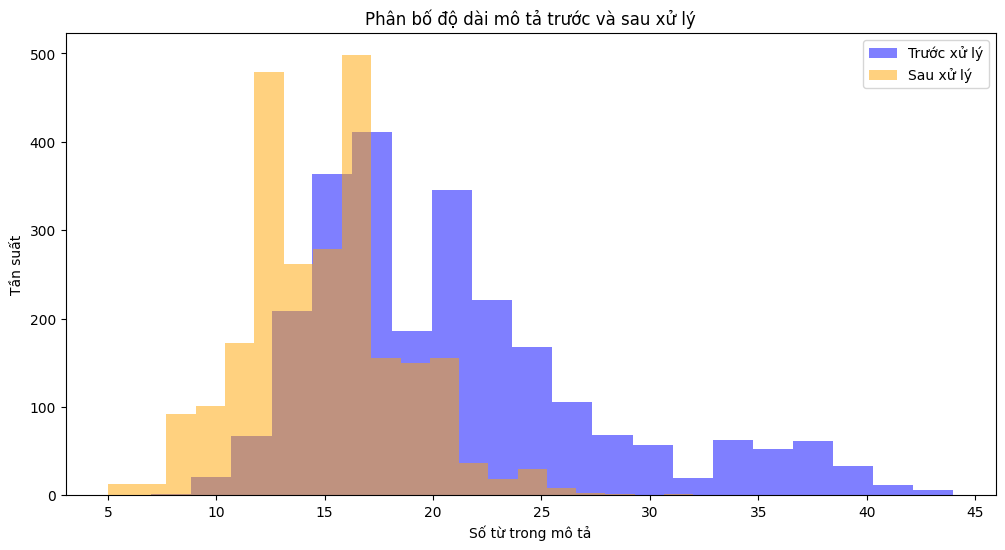

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Đọc dữ liệu trước và sau xử lý
df_before = pd.read_csv('crawl_data_articles.csv')
df_after = pd.read_csv('data_articles_cleaned.csv')

# 2. Kiểm tra và làm sạch bổ sung (nếu cần)
# Loại bỏ các dòng có title hoặc description rỗng
df_after = df_after.dropna(subset=['title', 'description']).reset_index(drop=True)

# 3. Tính độ dài văn bản (số từ) để so sánh
df_before['title_length'] = df_before['title'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
df_after['title_length'] = df_after['title'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

df_before['description_length'] = df_before['description'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
df_after['description_length'] = df_after['description'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

# 4. Trực quan hóa sự thay đổi

# Histogram cho title_length
plt.figure(figsize=(12, 6))
plt.hist(df_before['title_length'], bins=20, alpha=0.5, label='Trước xử lý', color='blue')
plt.hist(df_after['title_length'], bins=20, alpha=0.5, label='Sau xử lý', color='orange')
plt.title('Phân bố độ dài tiêu đề trước và sau xử lý')
plt.xlabel('Số từ trong tiêu đề')
plt.ylabel('Tần suất')
plt.legend()
plt.show()

# Box plot cho title_length
df_before['title_length'] = df_before['title'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
df_after['title_length'] = df_after['title'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

# Gộp dữ liệu
df_combined = pd.DataFrame({
    'title_length': pd.concat([df_before['title_length'], df_after['title_length']], ignore_index=True),
    'Xử lý': ['Trước xử lý'] * len(df_before) + ['Sau xử lý'] * len(df_after)
})

# Vẽ Box Plot (khắc phục cảnh báo)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Xử lý', y='title_length', hue='Xử lý', data=df_combined, palette=['blue', 'orange'], legend=False)
plt.title('Box plot độ dài tiêu đề trước và sau xử lý')
plt.xlabel('')
plt.ylabel('Số từ trong tiêu đề')
plt.show()

# Histogram cho description_length
plt.figure(figsize=(12, 6))
plt.hist(df_before['description_length'], bins=20, alpha=0.5, label='Trước xử lý', color='blue')
plt.hist(df_after['description_length'], bins=20, alpha=0.5, label='Sau xử lý', color='orange')
plt.title('Phân bố độ dài mô tả trước và sau xử lý')
plt.xlabel('Số từ trong mô tả')
plt.ylabel('Tần suất')
plt.legend()
plt.show()


# **3. Mã hoá dữ liệu**

TF-IDF
TF-IDF là một kỹ thuật dùng để đánh giá tầm quan trọng của một từ trong một tài liệu so với toàn bộ tập hợp tài liệu. Nó kết hợp hai thành phần chính:
- Term Frequency (TF - Tần suất xuất hiện của từ): Đo lường số lần một từ xuất hiện trong một tài liệu.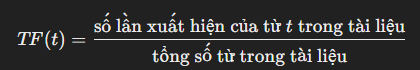
- Inverse Document Frequency (IDF - Tần suất nghịch của tài liệu): Đánh giá mức độ quan trọng của từ dựa trên số tài liệu có chứa từ đó.
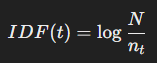

Trong đó:
- N là tổng số tài liệu trong tập dữ liệu.
- nt là số tài liệu chứa từ t.
TF-IDF của một từ được tính bằng công thức:
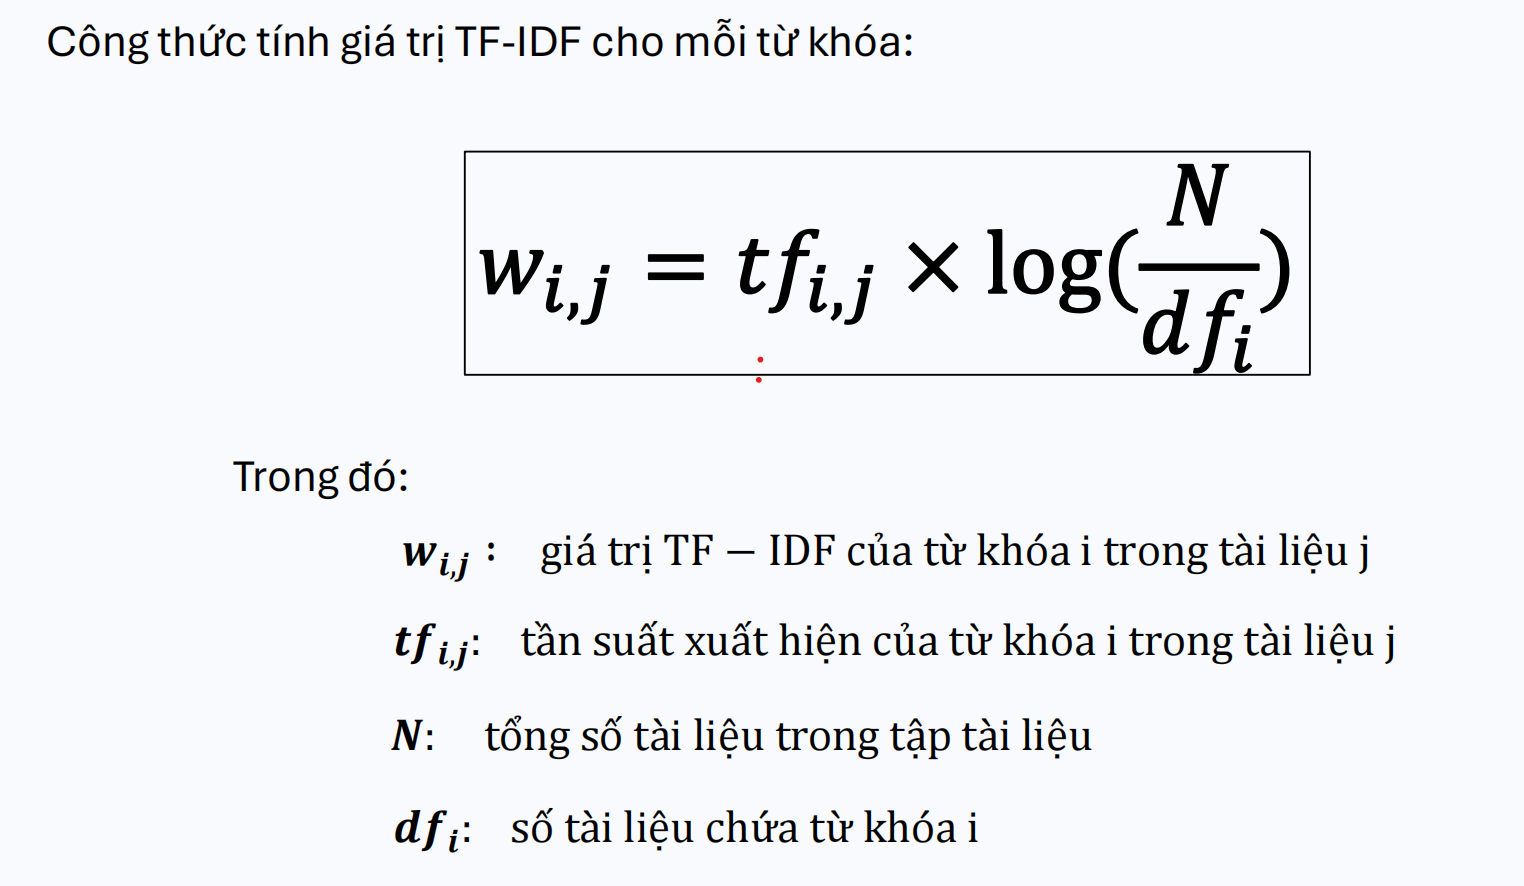
1. Xử lý ngôn ngữ và Vector hóa dữ liệu văn bản (Text Vectorization)

- Từ mỗi tài liệu, ta xây dựng một vector đặc trưng, với số chiều 𝐾 là số từ khóa được sử dụng trong tập tài liệu.
Vector cho mỗi tài liệu là một vector thưa (hầu hết các phần tử có giá trị bằng 0)




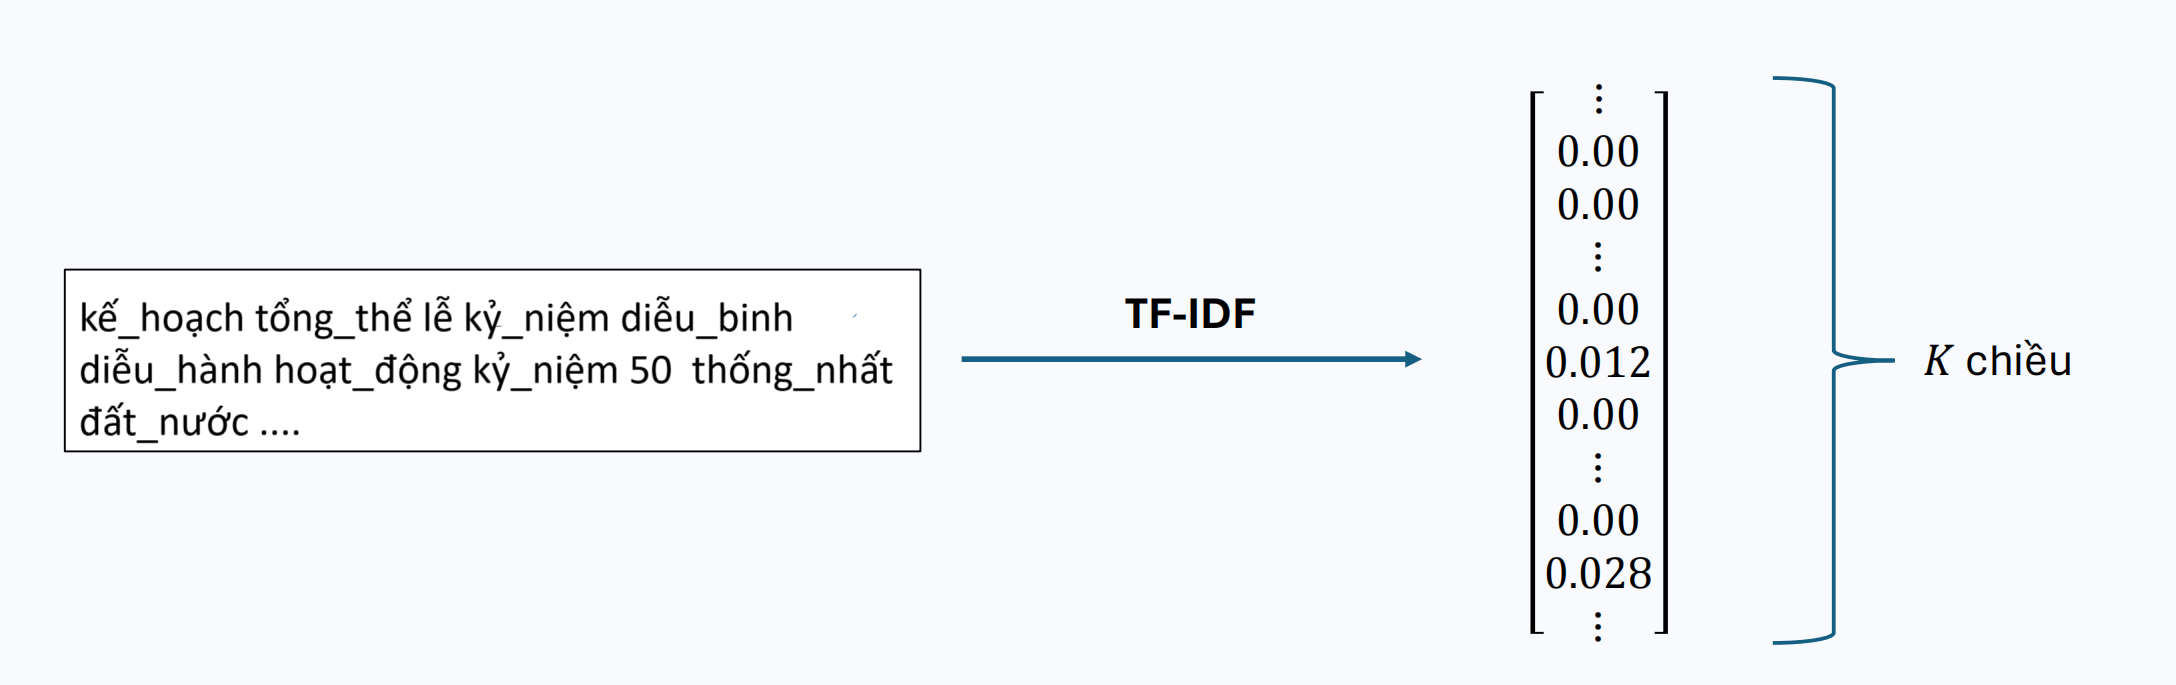

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk

# Cài đặt NLTK (nếu chưa cài đặt các tài nguyên)
nltk.download('stopwords')

# Đọc dữ liệu
df = pd.read_csv("data_articles_cleaned.csv")

# Tiền xử lý: lấy tiêu đề, mô tả, nội dung và thể loại
df = df[['title', 'description', 'content', 'category']].dropna()

# Ghép nội dung của các trường Tiêu đề, Mô tả và Nội dung lại thành cột text
df['text'] = df[['title', 'description', 'content']].astype(str).apply(' '.join, axis=1)

# =======================
# 1. Mã hóa dữ liệu cho cột 'category' bằng LabelEncoder
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

# =======================
# 2. Xử lý ngôn ngữ và Vector hóa dữ liệu văn bản (Text Vectorization)
# Đọc danh sách stopwords từ tệp
with open("stopwords_vn.txt", "r", encoding="utf-8") as f:
    stop_words_vietnamese = [line.strip() for line in f.readlines()]

# Sử dụng TF-IDF Vectorizer để tính trọng số của các từ trong văn bản
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_vietnamese)
X_tfidf = tfidf_vectorizer.fit_transform(df['text'])

# Chuyển ma trận TF-IDF thành DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Hiển thị top 10 từ có trọng số TF-IDF cao nhất
top_tfidf_words = tfidf_df.sum(axis=0).sort_values(ascending=False).head(10)
print("\nTop 10 từ có trọng số TF-IDF cao nhất:")
print(top_tfidf_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ảnh'] not in stop_words.
  warnings.warn(



Top 10 từ có trọng số TF-IDF cao nhất:
trường        62.486932
đại_học       52.681688
việt_nam      50.422681
học_sinh      44.906057
thi           42.697722
tỉnh          40.477342
phát_triển    37.087361
công_nghệ     36.939787
tp            33.534200
nghiên_cứu    33.356871
dtype: float64


In [ ]:
category_mapping = dict(zip(df['category'], df['category_encoded']))
print(category_mapping)

{'Thời sự': 10, 'Kinh doanh': 5, 'Khoa học': 4, 'Sức khỏe': 7, 'Thể thao': 9, 'Giải trí': 3, 'Giáo dục': 2, 'Du lịch': 1, 'Pháp luật': 6, 'Văn hóa': 11, 'Công nghệ': 0, 'Thế giới': 8}


In [ ]:
import pandas as pd

# Chọn dòng thứ 5 và hiển thị dưới dạng DataFrame
row_index = 4  # Bạn có thể thay đổi chỉ số này
tfidf_row = pd.DataFrame(tfidf_df.iloc[row_index]).reset_index()
tfidf_row.columns = ['Từ', 'Trọng số TF-IDF']
print(tfidf_row.sort_values(by='Trọng số TF-IDF', ascending=False).head(20))  # Hiển thị top 20 từ có trọng số cao nhất

                   Từ  Trọng số TF-IDF
9344             cháy         0.483586
26324             lửa         0.335272
50896          xe_máy         0.181731
17055             gác         0.156326
6906         bùng_lên         0.149700
45174  trần_thị_chánh         0.144406
54765          đổ_sụp         0.134944
51284         xóm_củi         0.128711
52346        đang_ngủ         0.118727
34965          phường         0.114101
14754          em_gái         0.112275
12241       cầu_thang         0.112275
12660             cứu         0.108814
50906         xe_điện         0.102382
47104            tầng         0.101639
10588          con_rể         0.101278
14114       dưới_tầng         0.096271
23551          kể_lại         0.095967
52976             đám         0.095085
9337             cháu         0.093047


# **4. Xây dựng và lựa chọn đặc trưng**

1. Đọc dữ liệu
2. Tạo đặc trưng
- Độ dài văn bản
- Số lượng từ ghép
3. Chuyển đổi văn bản thành đặc trưng số (TF-IDF)
4. Mã hoá biến mục tiêu
5. Gộp các đặc trưng bổ sung với TF-IDF
6. Lựa chọn đặc trưng (Feature Selection)
- Sử dụng Chi-squared test để chọn 500 đặc trưng quan trọng nhất
7. Trực quan hóa độ quan trọng của một số đặc trưng

Các đặc trưng được chọn: ['2025', '31', 'an_khang', 'bangkok', 'bao_gồm', 'bay', 'biên_giới', 'biển', 'buộc', 'bài_thi', 'bàn', 'bác_sĩ', 'bách_khoa', 'bán_dẫn', 'báo_cáo', 'bãi', 'bé', 'bình_luận', 'bóng', 'bóng_đá', 'bản_thân', 'bảng', 'bất_động_sản', 'bậc', 'bắt', 'bền_vững', 'bệnh', 'bệnh_nhân', 'bệnh_viện', 'bị_cáo', 'bồi_thường', 'bộ_giáo_dục_và_đào_tạo', 'ca', 'ca_khúc', 'ca_sĩ', 'chiếm_đoạt', 'chiến_dịch', 'chiến_thắng', 'cho_phép', 'chung_kết', 'chuyên', 'chuyến', 'chuyến_bay', 'chuỗi', 'châu_á', 'châu_âu', 'chính_quyền', 'chính_sách', 'chùa', 'chúng_tôi', 'chăm_sóc', 'chương_trình', 'chạy', 'chấn_thương', 'chất', 'chẩn_đoán', 'chế_tạo', 'chế_độ', 'chỉ_tiêu', 'chống', 'chồng', 'chở', 'chủ', 'chủ_tịch', 'chứa', 'chức_năng', 'chứng_chỉ', 'chứng_khoán', 'clb', 'con_gái', 'con_người', 'con_trai', 'cuộc_sống', 'cuộc_thi', 'cuộc_đời', 'cà_phê', 'cán_bộ', 'cáo_buộc', 'câu_chuyện', 'có_thể', 'cô_gái', 'công_an', 'công_nghệ', 'công_ty', 'cơ_hội', 'cơ_quan', 'cơ_thể', 'cải_thiện', 'cảm_

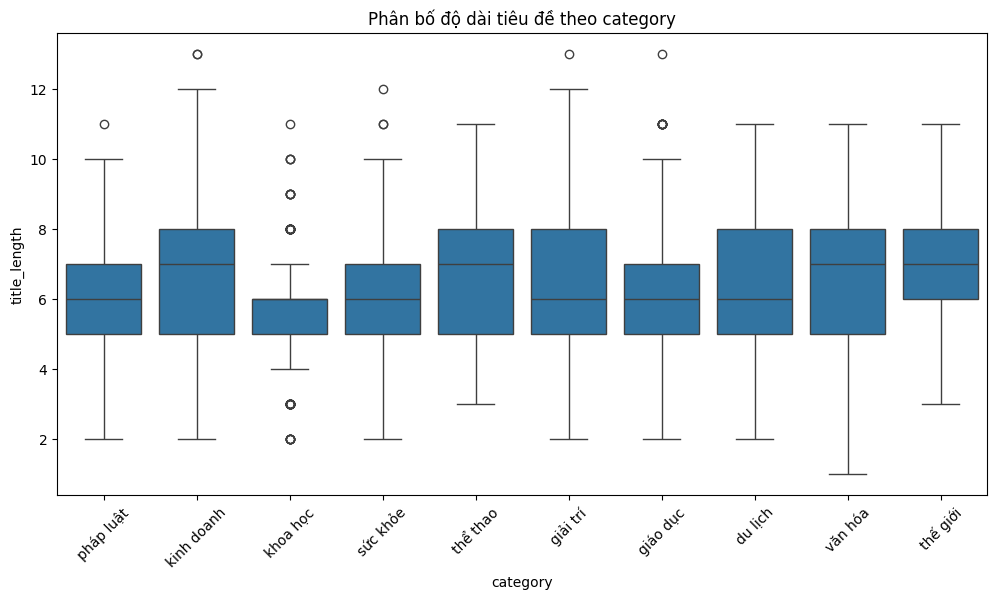

Đã lưu dữ liệu đặc trưng vào 'data_articles_features.csv'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Đọc dữ liệu
df = pd.read_csv('data_articles_cleaned.csv')

# 2. Tạo đặc trưng bổ sung
# Độ dài văn bản
df['title_length'] = df['title'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
df['description_length'] = df['description'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
df['content_length'] = df['content'].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)

# Số lượng từ ghép
df['title_compound_words'] = df['title'].apply(lambda x: sum(1 for word in str(x).split() if '_' in word))
df['description_compound_words'] = df['description'].apply(lambda x: sum(1 for word in str(x).split() if '_' in word))

# 3. Chuyển đổi văn bản thành đặc trưng số (TF-IDF)
# Gộp title, description, content thành một cột để vector hóa
df['combined_text'] = df['title'].fillna('') + ' ' + df['description'].fillna('') + ' ' + df['content'].fillna('')

# Sử dụng TF-IDF
tfidf = TfidfVectorizer(max_features=1000)  # Giới hạn 1000 đặc trưng
X_tfidf = tfidf.fit_transform(df['combined_text'])

# Chuyển thành DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# 4. Mã hóa biến mục tiêu (category)
le = LabelEncoder()
y = le.fit_transform(df['category'])

# 5. Gộp các đặc trưng bổ sung với TF-IDF
X_additional = df[['title_length', 'description_length', 'content_length', 'title_compound_words', 'description_compound_words']]
X = pd.concat([pd.DataFrame(X_tfidf.toarray()), X_additional.reset_index(drop=True)], axis=1)

# Đặt lại tên cột cho phù hợp
X.columns = list(tfidf.get_feature_names_out()) + ['title_length', 'description_length', 'content_length', 'title_compound_words', 'description_compound_words']

# 6. Lựa chọn đặc trưng (Feature Selection)
# Sử dụng Chi-squared test để chọn 500 đặc trưng quan trọng nhất
selector = SelectKBest(chi2, k=500)
X_selected = selector.fit_transform(X, y)

# Lấy danh sách các đặc trưng được chọn
selected_features = X.columns[selector.get_support()].tolist()
print("Các đặc trưng được chọn:", selected_features)

# 7. Trực quan hóa độ quan trọng của một số đặc trưng
# Vẽ biểu đồ phân bố độ dài tiêu đề theo category
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='title_length', data=df)
plt.title('Phân bố độ dài tiêu đề theo category')
plt.xticks(rotation=45)
plt.show()

# 8. Lưu dữ liệu đã xử lý
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
X_selected_df['category'] = df['category']
X_selected_df.to_csv('data_articles_features.csv', index=False, encoding='utf-8-sig')
print("Đã lưu dữ liệu đặc trưng vào 'data_articles_features.csv'")

# **5. Trực quang hoá dữ liệu**

1. Sử dụng thư viện: Matplotlib, Seaborn
  -

<ipython-input-20-d22e58dffd6d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_tfidf_words.values, y=top_tfidf_words.index, palette='viridis')


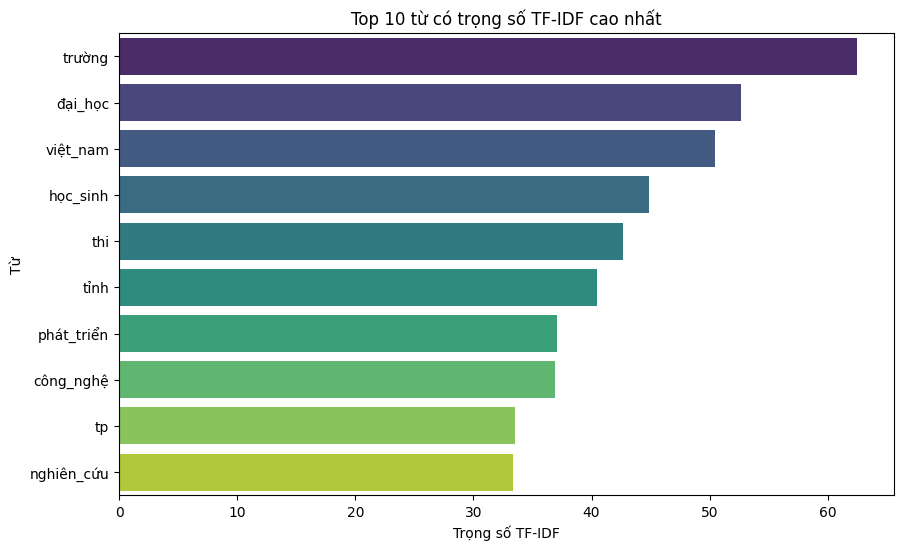

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# =======================
# Vẽ biểu đồ tần suất các từ có trọng số TF-IDF cao nhất
plt.figure(figsize=(10, 6))
sns.barplot(x=top_tfidf_words.values, y=top_tfidf_words.index, palette='viridis')
plt.title("Top 10 từ có trọng số TF-IDF cao nhất")
plt.xlabel("Trọng số TF-IDF")
plt.ylabel("Từ")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ảnh'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ảnh'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ảnh'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ảnh'] not in stop_words.
  warnings.warn(
/usr/local/lib/python3.11/dist-packa

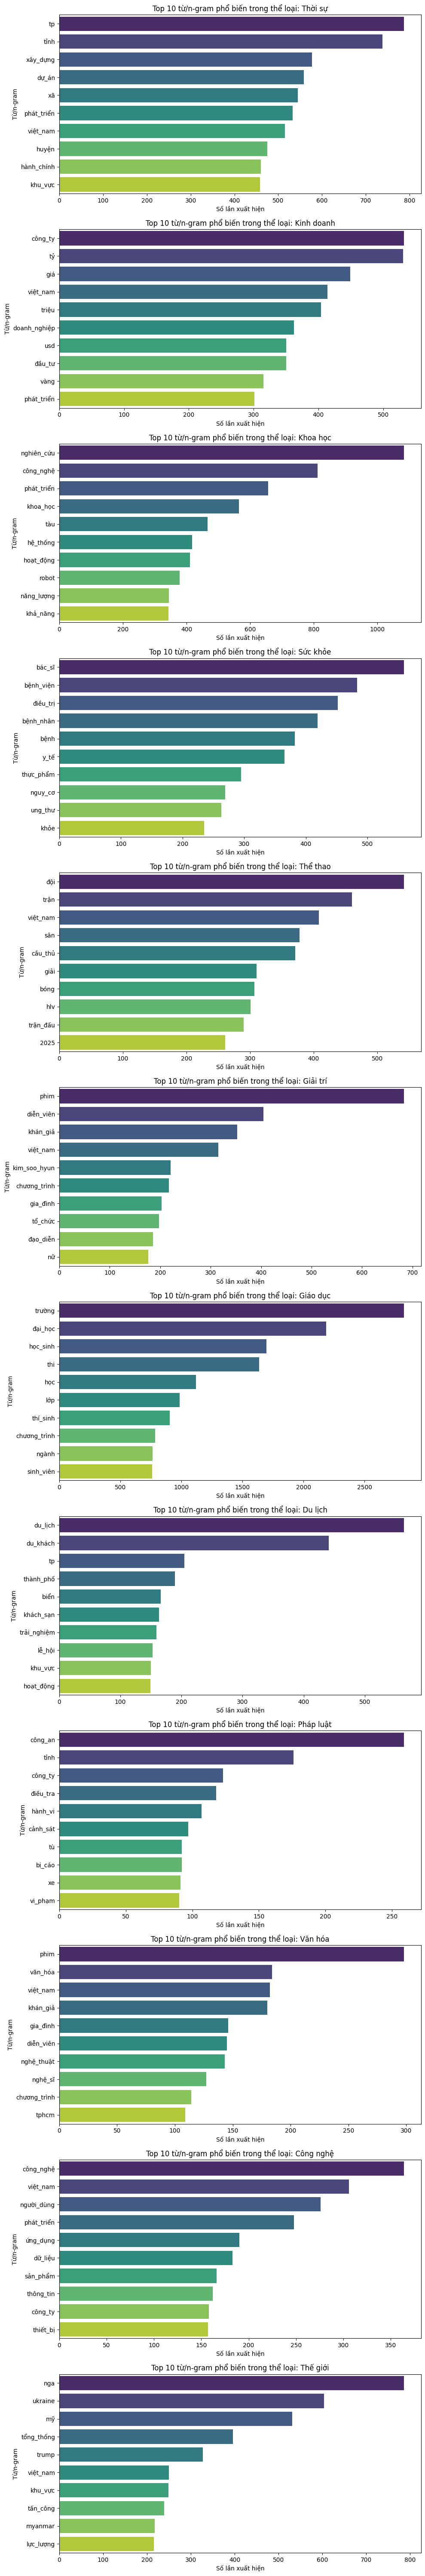

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc danh sách stopwords từ tệp
with open("stopwords_vn.txt", "r", encoding="utf-8") as f:
    stop_words_vietnamese = [line.strip() for line in f.readlines()]

# Đọc dữ liệu
df = pd.read_csv("data_articles_cleaned.csv")

# Tiền xử lý: lấy tiêu đề, mô tả, nội dung và thể loại
df = df[['title', 'description', 'content', 'category']].dropna()

# Ghép nội dung của các trường Tiêu đề, Mô tả và Nội dung lại thành cột text
df['text'] = df[['title', 'description', 'content']].astype(str).apply(' '.join, axis=1)

# Tạo hàm để tìm top 10 từ/n-gram trong mỗi thể loại
def get_top_n_words_by_category(df, stop_words, top_n=10):
    top_words_by_category = {}

    # Duyệt qua từng thể loại
    for category in df['category'].unique():
        # Lọc dữ liệu theo thể loại
        texts = df[df['category'] == category]['text']

        # Sử dụng CountVectorizer để tạo BoW với stopwords tiếng Việt và n-grams (unigrams + bigrams)
        vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=(1, 2))  # BoW + bigrams
        X = vectorizer.fit_transform(texts)

        # Chuyển ma trận thành DataFrame
        bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

        # Tính tổng tần suất của mỗi từ/n-gram
        word_frequencies = bow_df.sum(axis=0).sort_values(ascending=False)

        # Lấy top n từ/n-gram
        top_words_by_category[category] = word_frequencies.head(top_n)

    return top_words_by_category

# Lấy 10 từ/n-gram phổ biến cho mỗi thể loại
top_words_by_category = get_top_n_words_by_category(df, stop_words_vietnamese, top_n=10)

# Vẽ biểu đồ cho từng thể loại
fig, axes = plt.subplots(nrows=len(top_words_by_category), figsize=(10, 5 * len(top_words_by_category)))
if len(top_words_by_category) == 1:
    axes = [axes]  # Đảm bảo axes là danh sách khi chỉ có một thể loại

for ax, (category, words) in zip(axes, top_words_by_category.items()):
    sns.barplot(x=words.values, y=words.index, ax=ax, palette='viridis')
    ax.set_title(f"Top 10 từ/n-gram phổ biến trong thể loại: {category}")
    ax.set_xlabel("Số lần xuất hiện")
    ax.set_ylabel("Từ/n-gram")

plt.tight_layout()
plt.show()

# **6. Kết luận:**

Dữ liệu văn bản trong các bài báo điện tử là vô cùng nhiều. Có thể dễ dàng thu thập trên 1000 mẫu bài báo về 10 chủ đề khác nhau. Báo điện tử là nơi cập nhật tin tức thường xuyên nên dữ liệu vô cùng dồi dào và phong phú.

1. Đặc trưng dựa trên nội dung văn bản
TF-IDF features

2. Đặc trưng thống kê của văn bản
- Độ dài tiêu đề: Độ dài tiêu đề có thể liên quan đến loại bài báo (tin tức ngắn vs bài phân tích dài).
- Độ dài mô tả: Một số chủ đề có phần mô tả dài hơn bình thường.
- Độ dài nội dung: Bài báo phân tích thường dài hơn bài báo tường thuật.
- Số từ ghép.

# Hướng xây dựng mô hình
Thử nghiệm với mô hình khác: Bên cạnh các mô hình truyền thống như SVM, Random Forest, có thể thử deep learning (LSTM, BERT).





#**7.Tài liệu tham khảo**

1. Ninh Khánh Duy. "Slide bài giảng môn Khoa học Dữ liệu." Đại học Bách Khoa Đà Nẵng.
2. Phạm Đình Khánh. (2019). "Kỹ thuật Feature Engineering." Truy cập tại: [https://phamdinhkhanh.github.io/2019/01/07/Ky_thuat_feature_engineering.html](https://phamdinhkhanh.github.io/2019/01/07/Ky_thuat_feature_engineering.html).    
3. Grok AI (xAI). [https://grok.com/](https://grok.com/share/c2hhcmQtMg%3D%3D_6677dbf2-6467-479d-9aba-18703aeecb7b).  
4. Galli, Soledad - Python Feature Engineering Cookbook_ Over 70 Recipes for Creating, Engineering, and Transforming Features to Build Machine Learn (2020, Packt Publishing Ltd).pdf